In [40]:
import pandas as pd
import numpy as np
series= pd.read_csv('../input/12082021-data/data (5).csv')
series.drop(["API route","Http code"],inplace=True,axis=1)
series["Status"] = series.Status.map({"success":0,"failure":1})
series["Requests"] = 1
series.rename(columns={"Status": "Failure"}, inplace=True)
groupedData = series.groupby("Time").agg({"Response Time": "mean", "Failure": "sum", "Requests": "count"})
groupedData["Response Time"] = groupedData["Response Time"]/1000

In [41]:
copy = groupedData.copy()
copy["moving average"] = copy["Response Time"].rolling(window=5).mean()
copy.head()

,Response Time,Failure,Requests,moving average
Time,,,,
06:10:59 AM,5.25364,21,25,NaN
06:11:00 AM,0.94336,5,25,NaN
06:11:01 AM,1.04976,6,25,NaN
06:11:02 AM,0.92544,13,25,NaN
06:11:03 AM,0.89460,6,25,1.81336


In [42]:
data = copy.copy()
data.drop(columns=["Failure","Requests"],inplace=True)
data.rename(columns={"Response Time":"Average Response time"},inplace=True)
print(data)

             Average Response time  moving average
Time                                              
06:10:59 AM               5.253640             NaN
06:11:00 AM               0.943360             NaN
06:11:01 AM               1.049760             NaN
06:11:02 AM               0.925440             NaN
06:11:03 AM               0.894600        1.813360
...                            ...             ...
06:58:55 AM               2.944444        3.084367
06:58:56 AM               2.514944        3.008700
06:58:57 AM               3.597222        3.060456
06:58:58 AM               3.178056        3.137522
06:58:59 AM               3.357444        3.118422

[2881 rows x 2 columns]


<AxesSubplot:xlabel='Time', ylabel='Moving Average / Average Response Time'>

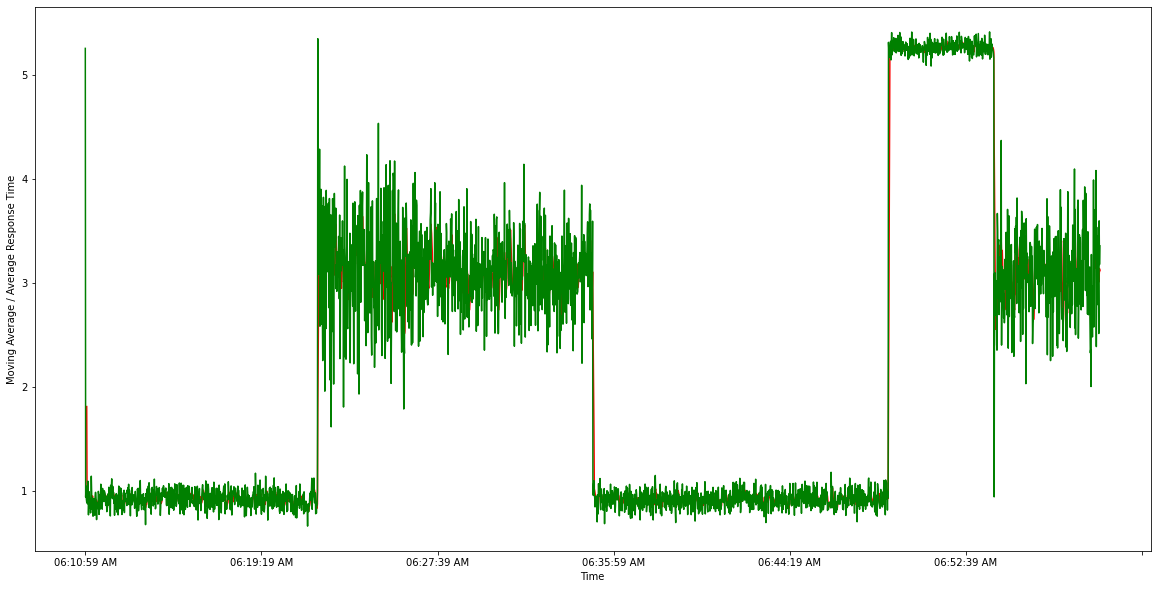

In [43]:
copy["moving average"].plot(ylabel="Moving Average",color="red")
copy["Response Time"].plot(ylabel="Moving Average / Average Response Time",color="green")

In [77]:
#import plotly.express as px
#a = px.line(copy,x=copy.index ,y="Response Time")
#ab = px.line(copy,x=copy.index ,y="moving average")
#a.show()
#ab.show()

In [45]:
#pip install statsmodels --upgrade
from statsmodels.tsa.ar_model import AutoReg

In [46]:
copy = data.copy()
copy = copy.drop(columns="Average Response time")
copy.dropna(inplace=True)
copy

,moving average
Time,
06:11:03 AM,1.813360
06:11:04 AM,0.952440
06:11:05 AM,0.939760
06:11:06 AM,0.949368
06:11:07 AM,0.967128
...,...
06:58:55 AM,3.084367
06:58:56 AM,3.008700
06:58:57 AM,3.060456


Coefficients: [0.00491841 0.99812125]
predicted=3.246395, expected=2.990022
predicted=3.245214, expected=3.202711
predicted=3.244036, expected=3.084367
predicted=3.242859, expected=3.008700
predicted=3.241685, expected=3.060456
predicted=3.240513, expected=3.137522
predicted=3.239344, expected=3.118422
Test RMSE: 0.172


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



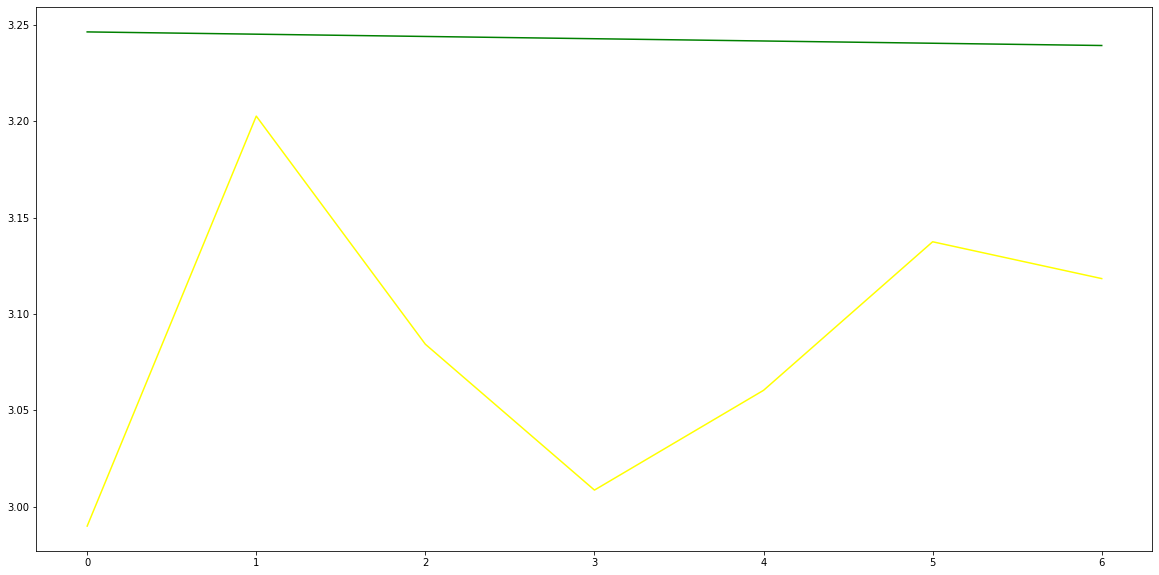

In [47]:
#Auto regression model
from matplotlib import pyplot
import statsmodels
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

X = copy.values
train,test = X[1:len(X)-7], X[len(X)-7:]
#model
# train autoregression
model = AutoReg(train, lags=1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test,color='yellow')
pyplot.plot(predictions, color='green')
pyplot.show()

In [53]:
copy.to_csv('mycsvfile4.csv',index=True)

In [80]:
#import packages
import pandas as pd
import numpy as np

#to plot 
import matplotlib.pyplot as plt
%matplotlib inline

#assuming fig px
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Read csv
df = pd.read_csv('./mycsvfile4.csv')
#print the head
df.head()

,Time,moving average
0,06:11:03 AM,1.813360
1,06:11:04 AM,0.952440
2,06:11:05 AM,0.939760
3,06:11:06 AM,0.949368
4,06:11:07 AM,0.967128


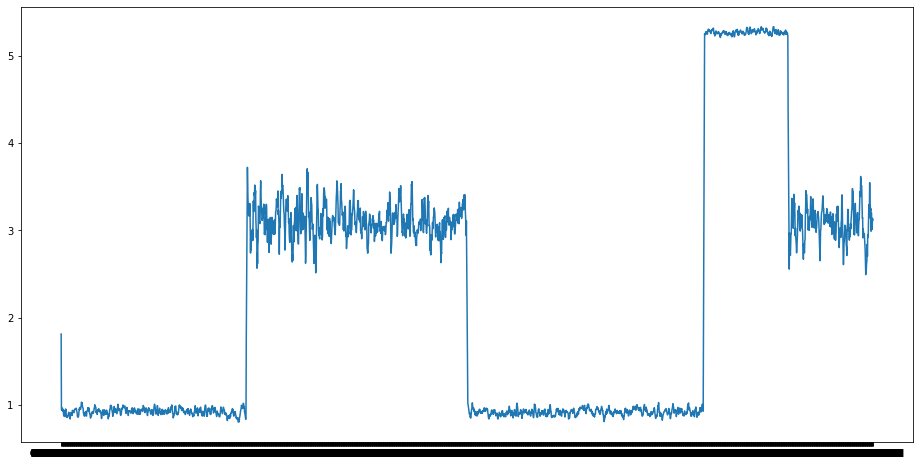

In [81]:
#setting index as Time
#df['Time'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Time']

#plot time vs mov avg
plt.figure(figsize=(16,8))
plt.plot(df['moving average'], label='Time vs moving average')

In [61]:
#importing libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [62]:
#dataframe creation
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Time', 'moving average'])
for i in range(0,len(data)):
    new_data['Time'][i] = data['Time'][i]
    new_data['moving average'][i] = data['moving average'][i]
    
#set index
new_data.index = new_data.Time
new_data.drop('Time', axis=1, inplace=True)

#to create train and test sets
dataset = new_data.values


In [65]:
#train and valid sets
train = dataset[0:900,:]
valid = dataset[900:,:]


In [78]:
#conversion of the dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(10,len(train)):
    x_train.append(scaled_data[i-10:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#The function takes a tuple as an argument that defines the new shape.
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


# creation and fitting into the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [70]:
#calculating loss 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=1)

890/890 [==============================] - 8s 7ms/step - loss: 0.0082


In [79]:
#predicting next 10 values, using past 10 from the train data
inputs = new_data[len(new_data) - len(valid) - 10:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(10,inputs.shape[0]):
    X_test.append(inputs[i-10:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
a = model.predict(X_test)
a = scaler.inverse_transform(a)
print(X_test.shape)


(1977, 10, 1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



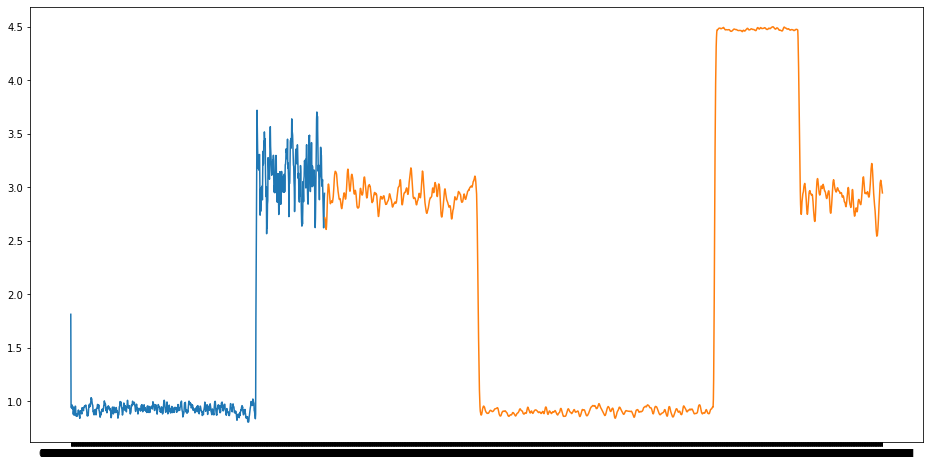

In [74]:
#plotting of forecasted and actual results
train = new_data[:900]
valid = new_data[900:]
valid['Predictions'] = a
plt.figure(figsize=(16,8))
plt.plot(train['moving average'])
plt.plot(valid[['Predictions']])


In [82]:
valid.to_csv('mycsvfile6.csv',index=True)

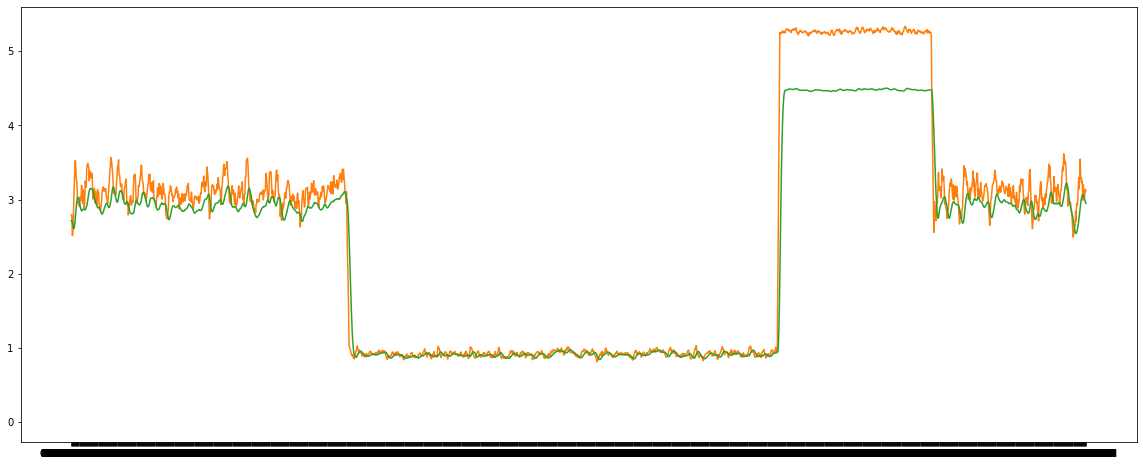

In [75]:
plt.figure(figsize=(20,8))
plt.plot(range(0, 1))
scale_factor = 1
plt.plot(valid[['moving average','Predictions']])

In [76]:
#plot fig
import plotly.express as px
a = px.line( valid,y="Predictions")
ab = px.line(valid,y="moving average")
a.show()
ab.show()